# load and inspect data

In [7]:
path_to_hpc    = "/content/HPC_100_CH2.continuous.mat"
path_to_pfc    = "/content/PFC_100_CH33.continuous.mat"
path_to_states = "/content/post_trial1_2018-02-22_09-59-19-states.mat"

In [8]:
config = emd.sift.SiftConfig.from_yaml_file("/content/emd_masksift_CA1_config_2500.yml")

In [9]:
import inspect
print(inspect.getsource(get_data))

def get_data(lfp_path, state_path, bregion):

    data = scipy.io.loadmat(lfp_path)
    states = scipy.io.loadmat(state_path)

    if bregion == 'PFC':
        lfp = np.squeeze(data['PFC'])
    else:
        lfp = np.squeeze(data['HPC'])
        
    hypno = np.squeeze(states['states'])

    fs = extract_frequency_sampling(lfp, hypno)

    unique = np.unique(hypno)
    if unique[0] == 0:
        print('There was 0 in the dataset')
        lfp = lfp[7*fs:-11*fs]
        hypno = hypno[7:-11]
    else:
        None

    return lfp, hypno, fs



In [12]:
lfpPFC, hypno1, fs = get_data(path_to_pfc, path_to_states, 'PFC')
print(fs)
lfpHPC, hypno2, fs = get_data(path_to_hpc, path_to_states, 'HPC')
print(fs)


2500
2500


In [13]:
print(len(lfpPFC))

6751488


In [14]:
np.unique(hypno2)

array([1, 3, 4, 5], dtype=uint8)

#Hypnogram

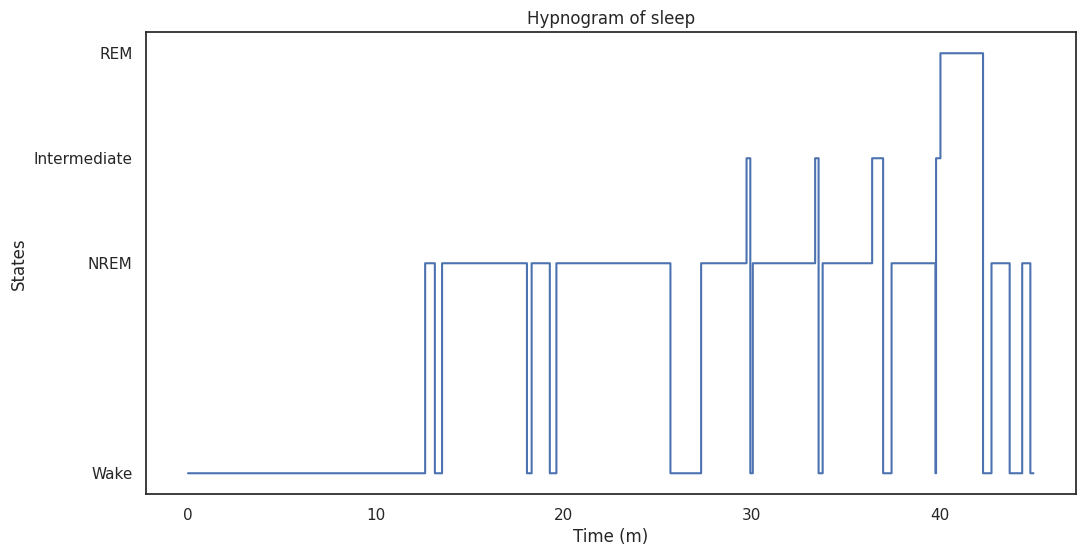

In [11]:
lfpHPC, hypno, fs = get_data(path_to_hpc, path_to_states, 'HPC')
plot_hypnogram(hypno)

#  Detect **REM**,theta cycles

# p/t REM

In [15]:
def extract_pt_intervals(lfpHPC, hypno, fs=2500):
    targetFs = 500
    n_down = fs / targetFs
    start, end = get_start_end(hypno=hypno, sleep_state_id=5)
    rem_interval = nap.IntervalSet(start=start, end=end)
    fs = int(n_down * targetFs)
    t = np.arange(0, len(lfpHPC) / fs, 1 / fs)
    lfp = nap.TsdFrame(t=t, d=lfpHPC, columns=['HPC'])

    # Detect phasic intervals
    lfpHPC_down = preprocess(lfpHPC, n_down)
    phREM = detect_phasic(lfpHPC_down, hypno, targetFs)

    # Create phasic REM IntervalSet
    start, end = [], []
    for rem_idx in phREM:
        for s, e in phREM[rem_idx]:
            start.append(s / targetFs)
            end.append(e / targetFs)
    phasic_interval = nap.IntervalSet(start, end)

    # Calculate tonic intervals
    tonic_interval = rem_interval.set_diff(phasic_interval)
    print(f'Number of detected Tonic intrevals:{len(tonic_interval)}')
    # Apply a 100 ms duration threshold to tonic intervals
    min_duration = 0.1  # 100 ms in seconds
    durations = tonic_interval['end'] - tonic_interval['start']
    valid_intervals = durations >= min_duration
    tonic_interval = nap.IntervalSet(tonic_interval['start'][valid_intervals], tonic_interval['end'][valid_intervals])
    print(f'Number of detected Tonic intrevals after threshold:{len(tonic_interval)}')
    return phasic_interval, tonic_interval, lfp

In [16]:
#N intervals
phasic_interval, tonic_interval, lfp = extract_pt_intervals(lfpHPC, hypno)

Number of detected Tonic intrevals:4
Number of detected Tonic intrevals after threshold:4


# to get theta cycle

In [17]:
def get_cycle_data(imf5, fs=2500):
    cycle_data = {"fs": None, 'theta_imf': None,
                       "IP": None, "IF": None, "IP": None, "cycles": None}


    # Get cycles using IP
    IP, IF, IA = emd.spectra.frequency_transform(imf5, fs, 'hilbert')
    C = emd.cycles.Cycles(IP)
    cycles = get_cycles_with_metrics(C, imf5, IA, IF)

    cycle_data['fs'] = fs
    cycle_data['theta_imf'] = imf5
    cycle_data['IP'] = IP
    cycle_data['IF'] = IF
    cycle_data['IA'] = IA
    cycle_data['cycles'] = cycles
    return cycle_data

In [18]:
def extract_imfs_by_pt_intervals(lfp, fs, interval, config, return_imfs_freqs=False):

    all_imfs = []
    all_imf_freqs = []
    rem_lfp = []
    all_masked_freqs = []
    for ii in range(len(interval)):
        start_idx = int(interval.loc[ii, 'start'] * fs)
        end_idx = int(interval.loc[ii, 'end'] * fs)
        sig_part = lfp[start_idx:end_idx]
        sig = np.array(sig_part)

        rem_lfp.append(sig)

        try:
            imf, mask_freq = sift.mask_sift(sig, **config)
        except Exception as e:
            print(f"EMD Sift failed: {e}. Skipping this interval.")
            continue
        all_imfs.append(imf)
        all_masked_freqs.append(mask_freq)

        imf_frequencies = imf_freq(imf, fs)
        all_imf_freqs.append(imf_frequencies)

    if return_imfs_freqs:
        return all_imfs, all_imf_freqs, rem_lfp
    else:
        return all_imfs

In [19]:
phasic_imfs, phasic_imfs_freqs, rem_lpf = extract_imfs_by_pt_intervals(lfp, fs, phasic_interval, config, return_imfs_freqs=True)
tonic_imfs, tonic_imfs_freqs, tonic_rem_lpf = extract_imfs_by_pt_intervals(lfp, fs, tonic_interval, config, return_imfs_freqs=True)

In [26]:
print("Tonic intervals imfs:")
for i, imf_mat in enumerate(tonic_imfs):
    print(f"Interval {i}: {imf_mat.shape}")  # (n_samples_in_interval, n_imfs)
print("-----------------------------------")
print("Phasic intervals imfs:")
for i, imf_mat in enumerate(phasic_imfs):
    print(f"Interval {i}: {imf_mat.shape}")

Tonic intervals imfs:
Interval 0: (60454, 6)
Interval 1: (31180, 6)
Interval 2: (73481, 6)
Interval 3: (155680, 6)
-----------------------------------
Phasic intervals imfs:
Interval 0: (2496, 6)
Interval 1: (10649, 6)
Interval 2: (3560, 6)


In [28]:
freqs_intervalll = tonic_imfs_freqs[0]
print("Frequencies for tonic interval 0:")
for imf_idx, freqs in enumerate(freqs_intervalll):
    print(f"IMF {imf_idx+1}: freq = {freqs}")
freqs_intervalll = phasic_imfs_freqs[0]
print("Frequencies for phasic interval 0:")
for imf_idx, freqs in enumerate(freqs_intervalll):
    print(f"IMF {imf_idx+1}: freq = {freqs}")

Frequencies for tonic interval 0:
IMF 1: freq = 306.54464276868583
IMF 2: freq = 108.75888458032895
IMF 3: freq = 54.042221927617945
IMF 4: freq = 25.714571296369364
IMF 5: freq = 16.285683648538367
IMF 6: freq = 7.319277899257904
Frequencies for phasic interval 0:
IMF 1: freq = 295.69622240694054
IMF 2: freq = 92.8538650388441
IMF 3: freq = 48.85467612206858
IMF 4: freq = 22.78851677355542
IMF 5: freq = 17.63949250668455
IMF 6: freq = 9.01557141145768


In [20]:
def extract_cycle_info(imfs, imf_frequencies):

  all_FPPs = []
  all_cycles_se =[]
  all_cycles_ctrl = []

  theta_range = [5, 12]
  frequencies = np.arange(15, 141, 1)
  angles=np.linspace(-180,180,19)
  fs = 2500

  for idx, imf in enumerate(imfs):
    cycle_data = get_cycle_data(imf[:, 5], fs=2500)

    amp_thresh = np.percentile(cycle_data['IA'], 25) # higher than 25th percentile of the data
    lo_freq_duration = fs/5  # restrict the analysis to 5-12 Hz
    hi_freq_duration = fs/12

    conditions = ['is_good==1',
                        f'duration_samples<{lo_freq_duration}',
                        f'duration_samples>{hi_freq_duration}',
                        f'max_amp>{amp_thresh}']

    all_cycles = get_cycles_with_conditions(cycle_data['cycles'], conditions)

    subset_cycles_df = all_cycles.get_metric_dataframe(subset=True)
    subset_indices = subset_cycles_df['index'].values

    ctrl = emd.cycles.get_control_points(imf[:, 5], cycle_data['cycles'], mode='augmented')
    cycle_ctrls = get_cycle_ctrl(ctrl, subset_indices)
    all_cycles_ctrl.append(cycle_ctrls)
    all_cycles_inds = get_cycle_inds(all_cycles, subset_indices)
    cycles_inds = arrange_cycle_inds(all_cycles_inds)

    all_cycles_se.append(all_cycles_inds)

    freqs = imf_frequencies[idx]
    sub_theta, theta, supra_theta = tg_split(freqs, theta_range)
    supra_theta_sig = np.sum(imf.T[supra_theta], axis=0)

    # # Corrected Wavelet Transform Computation
    raw_data=sails.wavelet.morlet(supra_theta_sig, freqs=frequencies, sample_rate=fs, ncycles=5,ret_mode='power', normalise=None)
    supraPlot = scipy.stats.zscore(raw_data, axis=1)
    FPP = bin_tf_to_fpp(cycles_inds, supraPlot, bin_count=19)
    all_FPPs.append(FPP)

  return all_cycles_ctrl, all_cycles_se, all_FPPs

In [21]:
all_phasic_cycle_ctrls, all_phasic_cycles_se, all_phasic_FPPs = extract_cycle_info(phasic_imfs, phasic_imfs_freqs)
all_tonic_cycle_ctrls, all_tonic_cycles_se, all_tonic_FPPs = extract_cycle_info(tonic_imfs, tonic_imfs_freqs)

 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'


# IMF

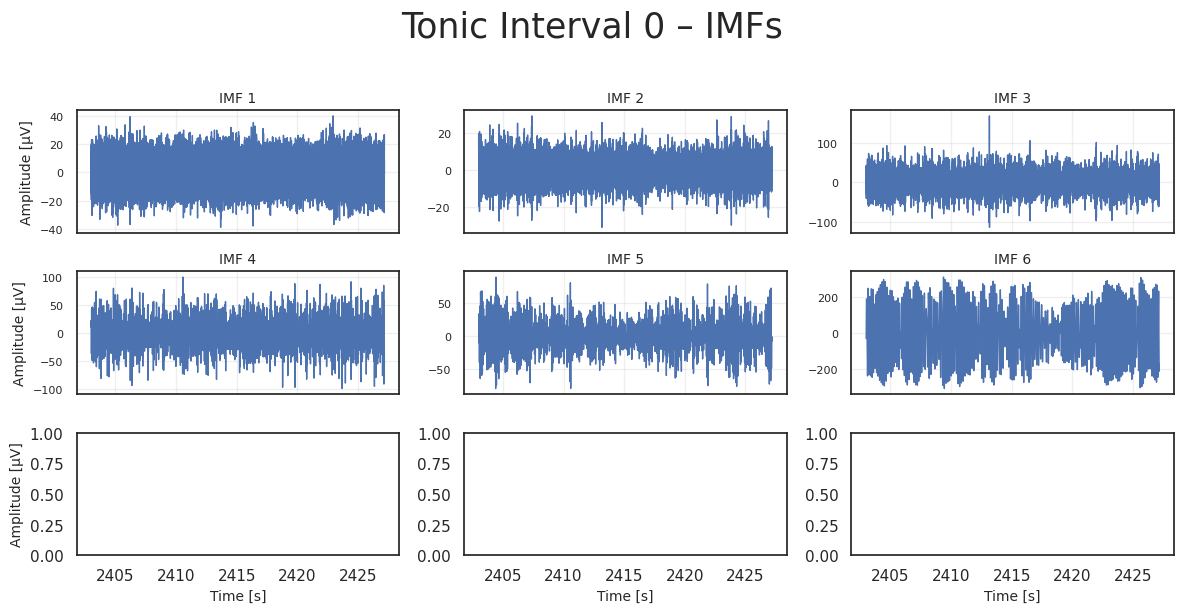

In [30]:
interval_idx = 0
imf_mat = tonic_imfs[interval_idx]
n_samples, n_imfs = imf_mat.shape

# Time axis in seconds
start_sec = float(tonic_interval.loc[interval_idx, 'start'])
end_sec   = float(tonic_interval.loc[interval_idx, 'end'])
t = np.linspace(start_sec, end_sec, n_samples)

# Create a 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(12, 6), sharex=True, sharey=False)
axes = axes.flatten()

for k in range(n_imfs):
    axes[k].plot(t, imf_mat[:, k], linewidth=1)
    axes[k].set_title(f"IMF {k+1}", fontsize=10)
    axes[k].tick_params(axis='both', which='major', labelsize=8)
    axes[k].grid(alpha=0.3)

# Add x and y labels to outer plots only
for ax in axes[6:]:  # bottom row x-labels
    ax.set_xlabel("Time [s]", fontsize=10)
for ax in axes[::3]:  # left column y-labels
    ax.set_ylabel("Amplitude [µV]", fontsize=10)

fig.suptitle(f"Tonic Interval {interval_idx} – IMFs", fontsize=25, y=1.02)
plt.tight_layout()
plt.show()

# FFP

In [22]:
frequencies = np.arange(15, 141, 1)
angles = np.linspace(-180, 180, 19)

In [23]:
FPP = all_phasic_FPPs[0]
all_cycles_inds = all_phasic_cycles_se[0]
all_cycles_ctrl = all_phasic_cycle_ctrls[0]
imf = phasic_imfs[0]
firstRemLFP = rem_lpf[0]

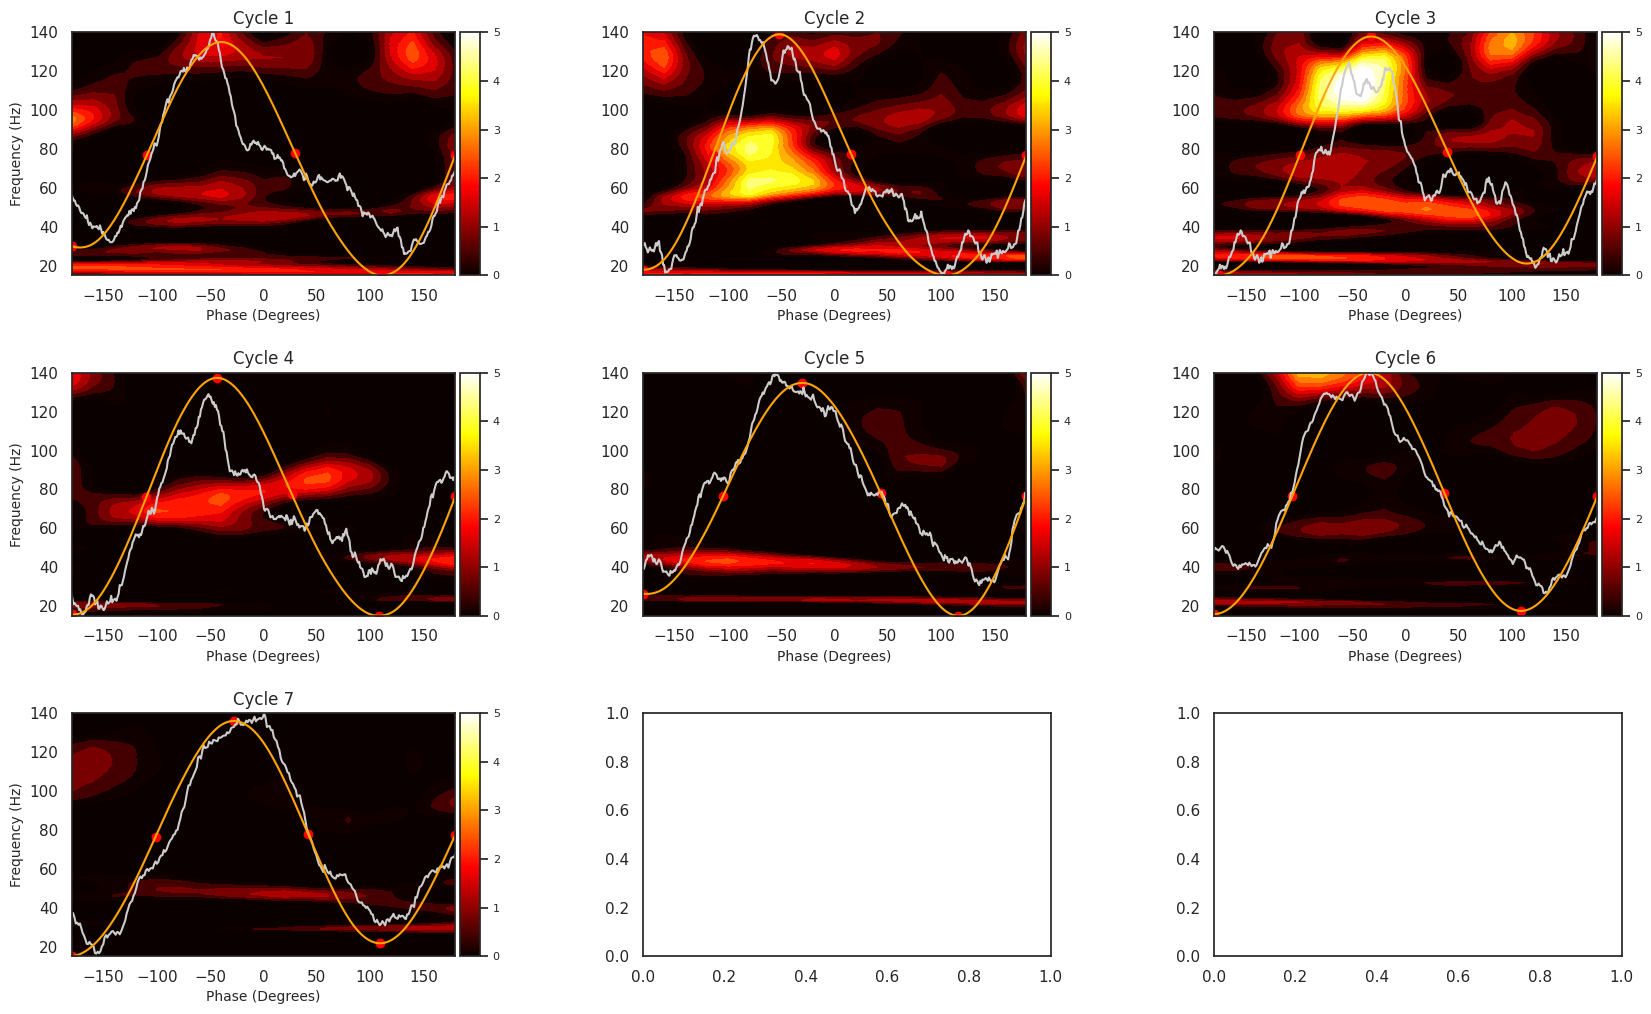

In [24]:
n_rows, n_cols = 3, 3
max_plots = n_rows * n_cols

vmin = 0
vmax = 5

n_levels = 20
levels = np.linspace(np.min(FPP), np.max(FPP), n_levels)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 12))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for ii in range(min(len(FPP), max_plots)):
    ax = axes[ii // n_cols, ii % n_cols]

    # Create contourf plot with specified levels and normalization
    im = ax.contourf(angles, frequencies, FPP[ii], levels=levels, cmap='hot', vmin=vmin, vmax=vmax)

    ax.set_xlabel(r'Phase (Degrees)', fontsize=10)
    if ii % n_cols == 0:
        ax.set_ylabel(r'Frequency (Hz)', fontsize=10)

    ax.set_title(f"Cycle {ii+1}", fontsize=12)

    xinds = np.arange(len(all_cycles_inds[ii]))
    raw_lfp = firstRemLFP[all_cycles_inds[ii]]
    theta_part = imf[all_cycles_inds[ii], 5]

    phase_scaled_xinds = np.linspace(angles.min(), angles.max(), len(xinds))
    lfp_scaled_y = (raw_lfp / np.max(np.abs(raw_lfp))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()
    theta_scaled_y = (theta_part / np.max(np.abs(theta_part))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()

    # Plot raw LFP and IMF-6 on the current axis
    ax.plot(phase_scaled_xinds, lfp_scaled_y, color=[0.8, 0.8, 0.8], label='Raw LFP')
    ax.plot(phase_scaled_xinds, theta_scaled_y, color='orange', label='IMF-6')

    # Plot control points
    ctrl_points_x = np.interp(all_cycles_ctrl[ii], np.arange(len(xinds)), phase_scaled_xinds)
    ctrl_points_y = (theta_part[all_cycles_ctrl[ii]] / np.max(np.abs(theta_part))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()
    ax.scatter(ctrl_points_x, ctrl_points_y, color='red', marker='o', label='Control Points')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = fig.colorbar(ScalarMappable(norm=im.norm, cmap=im.cmap), cax=cax, ticks=range(vmin, vmax+5, 5))
    im.set_clim(vmin, vmax)
    cbar.set_ticks(np.linspace(vmin, vmax, 6))
    cbar.ax.tick_params(labelsize=8)
plt.show()